# Gráficos normallizados con temperaturas

In [1]:
import sys
import os
from functools import reduce

project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datashader as ds
import holoviews as hv
from holoviews.operation.datashader import datashade

from src.utils import get_project_root
from src.data.make_dataset import get_minma_data

In [15]:
params = ['SO2','NO2', 'NO', 'NOX', 'O3', 'CO', 'MP10', 'MP25']#,'velviento'],#'dirviento']
params_quintero = ['SO2','NO2', 'NO', 'NOX', 'O3', 'CO', 'MP10', 'MP25', 'velviento']
params_maitenes = ['SO2','NO2', 'NO', 'NOX', 'O3', 'CO', 'MP10', 'MP25']
params_ventanas = ['SO2','NO2', 'NO', 'NOX', 'O3', 'MP10', 'MP25']
from_last = '5y'

In [18]:
def peak_df2(station, threshold, params, path):
    df = get_minma_data(params, station, from_last=from_last)
    cols_to_drop = list(df.filter(regex='(?<!no validados)_.*')) 
    df = df.drop(cols_to_drop, axis=1)
    df = df.reset_index().rename(columns={"Registros no validados_SO2": "SO2", "Registros no validados_NO2": "NO2", "Registros no validados_NO": "NO", "Registros no validados_NOX": "NOX", "Registros no validados_O3": "O3", "Registros no validados_CO": "CO", "Registros no validados_MP10": "MP10","Registros no validados_MP25": "MP25", "index": "date"})
    
    mask_peaks = df["SO2"] >= threshold
    peaks_df = df[mask_peaks]
    
    peaks_df['date'] = pd.to_datetime(peaks_df['date']).dt.date # date_time to dates
    crit_days = peaks_df["date"].unique() # unique peak days array
    
    values = [ df["date"].dt.date == day for day in crit_days ] # get a mask for each crit day
    mask_crit_days = reduce(lambda x,y: np.logical_or(x,y), values)
    
    # filtering df with the mask of critical days
    peaks_df = df[mask_crit_days]
    
    # storing the generated df
#     peaks_df.to_csv(path)
    
    return peaks_df, crit_days

In [19]:
quintero_peaks_df, quintero_crit_days = peak_df(station='quintero', threshold=133, params=params_quintero, path='generated/quintero_peaks.csv')

ValueError: Usecols do not match columns, columns expected but not found: [0, 1, 2, 3, 4]

In [5]:
def generate_var_hour_df( peaks_df, var_name ):
    df_var = peaks_df[["date", var_name]]
    df_var["Time"] = df_var["date"].dt.date
    df_var["Hour"] = df_var["date"].dt.hour
    df_var = df_var.pivot(index='Hour', columns='Time', values=var_name)
    return df_var

In [6]:
# funcion que genera un grafico por cada dia, y tambien un grafico de sombras con todos los dias juntos
def peak_day_plots(df, var_name, station, threshold=0):
    
    for c in range(len(df.columns)):
        # Plotting the time series of given dataframe
        plt.plot(df.index, df.iloc[:,[c]])
        # Plotting threshold
        if threshold > 0:
            plt.hlines(threshold, xmin=0, xmax=23, colors='r', linestyles='dashed')

        plt.title(f'{var_name} día {df.iloc[:,c].name}')

        # Providing x and y label to the chart
        plt.ylabel(f'Concentración {var_name} [ppb]')
        plt.xlabel('Hora')


        plt.savefig(f'generated/imgs_peaks/{station}/{var_name}/img_{c}')
        plt.show()

In [9]:
def plot_shade_df( df, var_name, station ):
    hv.extension('bokeh')
    opts = hv.opts.RGB(width=600, height=300)
    ndoverlay = hv.NdOverlay({c:hv.Curve((df.index, df.iloc[:,c]), kdims=['Time'], vdims=[var_name]) for c in range(len(df.columns))})
    return datashade(ndoverlay, cnorm='linear', aggregator=ds.count(), line_width=2).opts(opts)

In [10]:
def barplot_peaks( peaks_df, station , threshold):
    df = generate_var_hour_df( peaks_df, 'SO2' ) # var_hour format df
    df = df[ df >= threshold ] # turn non peak values into NaN
    df[ df >= threshold ] = 1 # turn peak values into 1
    df = (df.sum(axis=1)).astype('int32').to_frame().rename(columns={0: 'Cant_peaks'}) # sum amount of peaks per hour among peak days
    
    # bar plot of frecuncies
    fig = px.bar( x=df.index, 
                 y=df["Cant_peaks"], 
                 title=f'Cantidad de Peaks por Hora - Estación {station}', 
                 labels={'x':'Hora', 'y':'Cantidad de Peaks'})
#                 text_auto='.2s')
    fig.show()

## Quintero

Se generan gráficos asociados a quintero

In [17]:
quintero_peaks_df, quintero_crit_days = peak_df(station='quintero', threshold=133, params=params_quintero, path='generated/quintero_peaks.csv')

# Peak df for all variables
quintero_SO2 = generate_var_hour_df( quintero_peaks_df, "SO2" )
quintero_NO2 = generate_var_hour_df( quintero_peaks_df, "NO2" )
quintero_NO = generate_var_hour_df( quintero_peaks_df, "NO" )
quintero_NOX = generate_var_hour_df( quintero_peaks_df, "NOX" )
quintero_O3 = generate_var_hour_df( quintero_peaks_df, "O3" )
quintero_CO = generate_var_hour_df( quintero_peaks_df, "CO" )
quintero_MP10 = generate_var_hour_df( quintero_peaks_df, "MP10" )
quintero_MP25 = generate_var_hour_df( quintero_peaks_df, "MP25" )

quintero_all_peaks_df = [quintero_SO2,quintero_NO2,quintero_NO, quintero_NOX, quintero_O3, quintero_CO, quintero_MP10, quintero_MP25]
quintero_all_var_names = ['SO2', 'NO2', 'NO', 'NOX', 'O3', 'CO', 'MP10', 'MP25']

ValueError: Usecols do not match columns, columns expected but not found: [0, 1, 2, 3, 4]

In [7]:
def all_var_plot2(all_peaks_df, all_var_names, station):
    df0 = all_peaks_df[0].columns
    for c in range(len(all_peaks_df[0].columns)): # for each column (day)
        for df_idx in range(len(all_peaks_df)): # for each index_df (df_variable)
            df = all_peaks_df[df_idx]
            plt.plot(df.index, df.iloc[:,[c]], label=all_var_names[df_idx]) # plot with variable legend
            plt.legend()

        plt.title(f'Dia {df.iloc[:,c].name}')
        plt.savefig(f'generated/imgs_peaks/{station}/all_variables/img_{c}')
        plt.show()

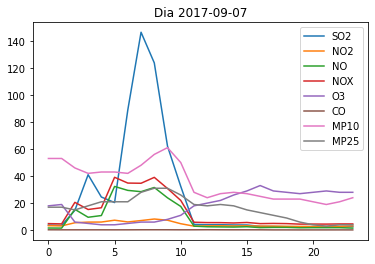

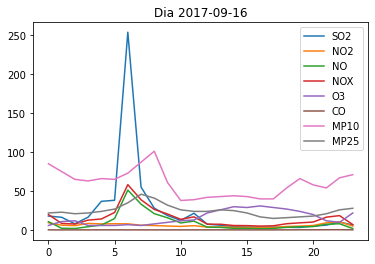

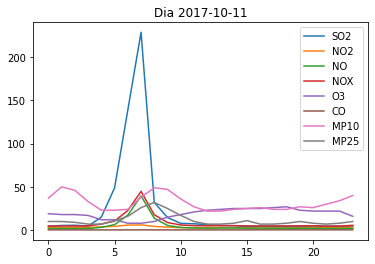

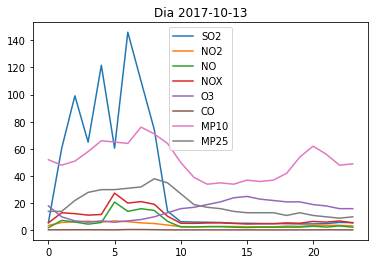

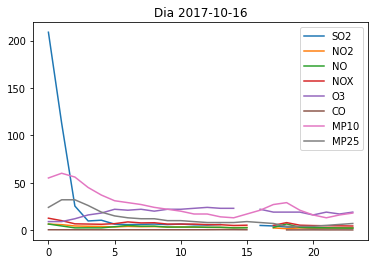

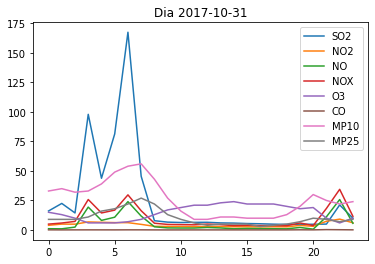

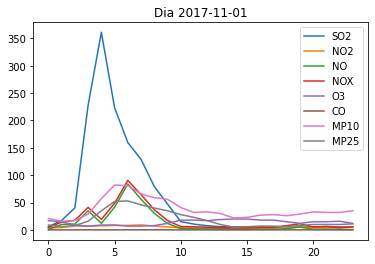

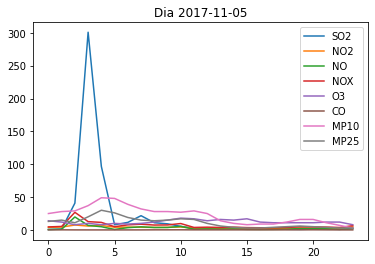

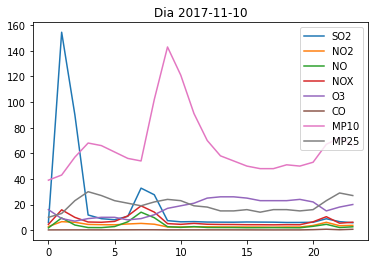

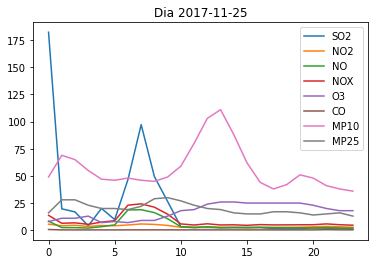

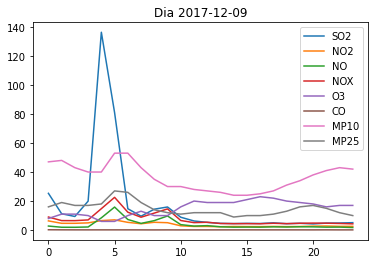

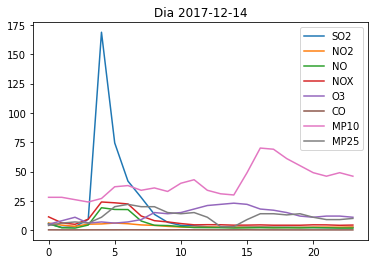

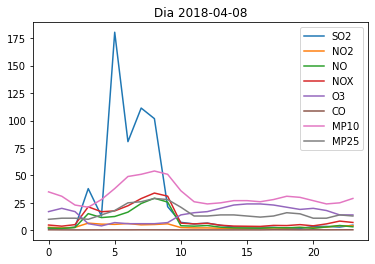

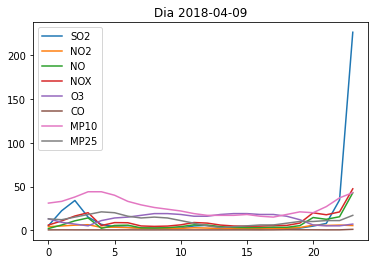

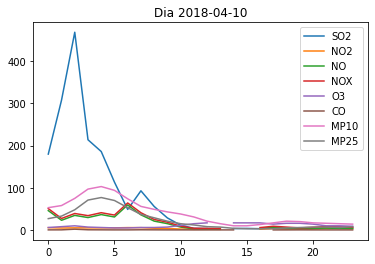

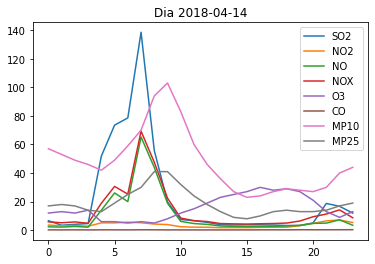

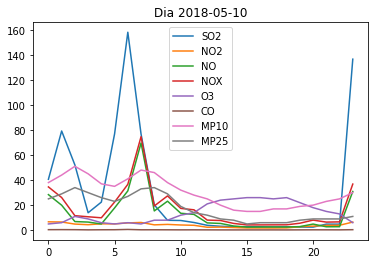

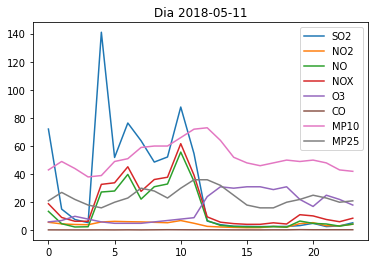

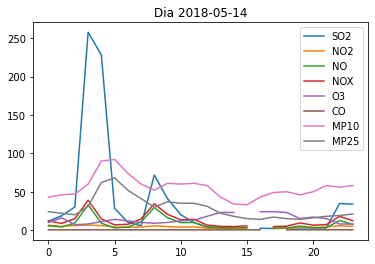

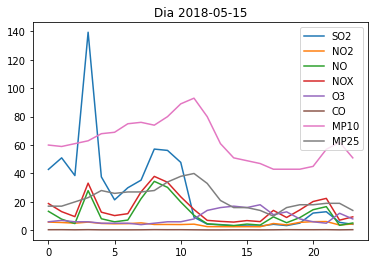

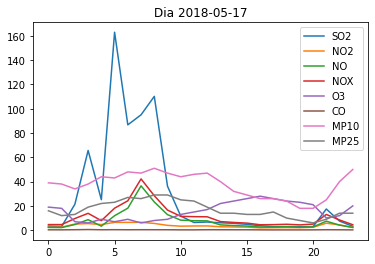

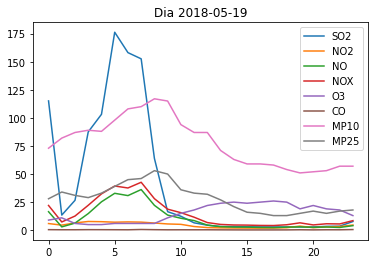

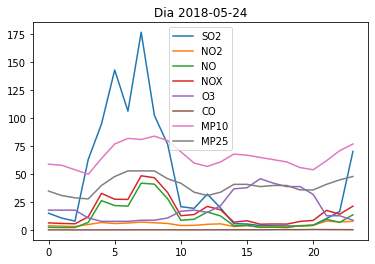

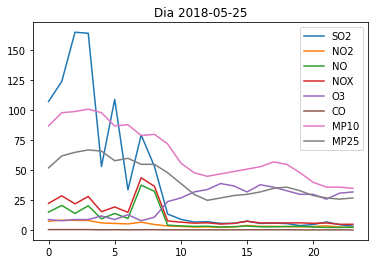

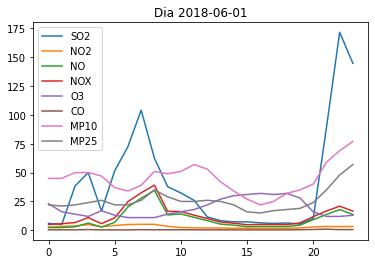

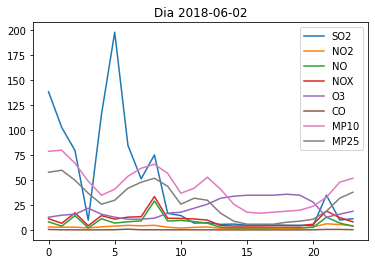

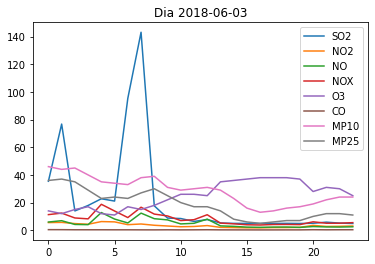

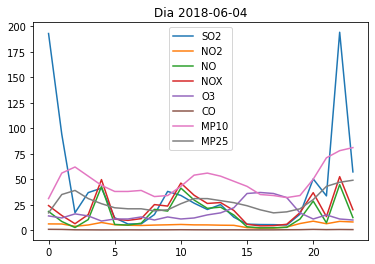

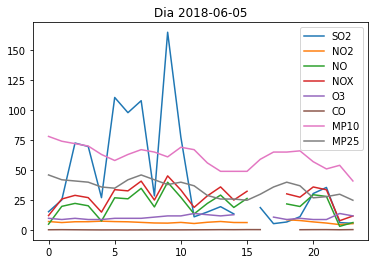

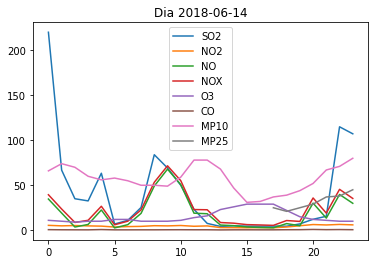

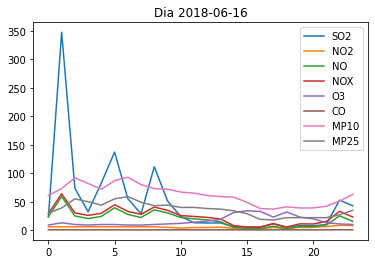

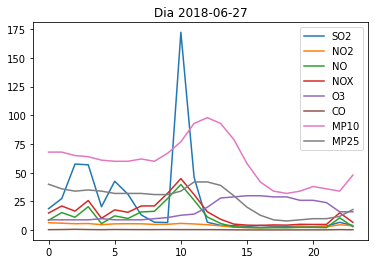

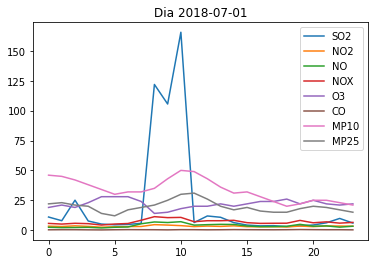

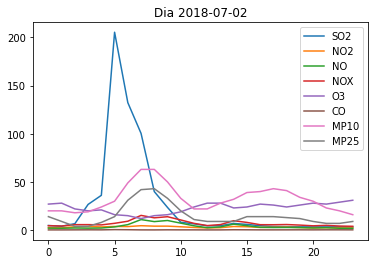

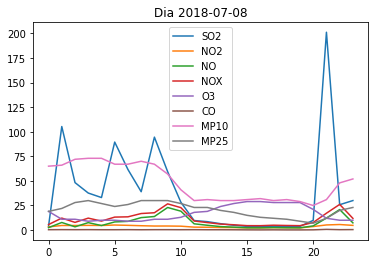

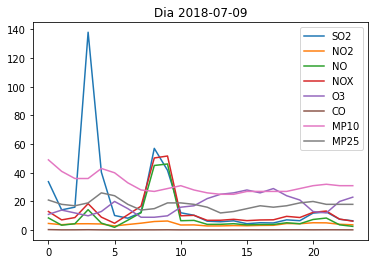

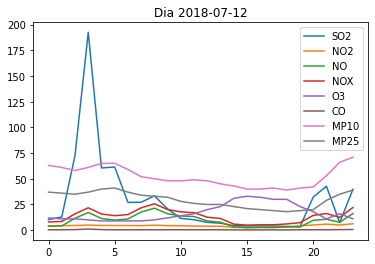

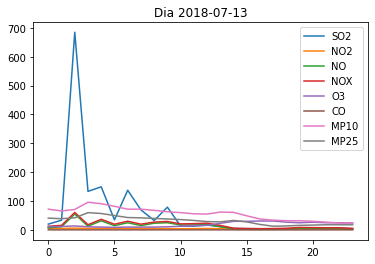

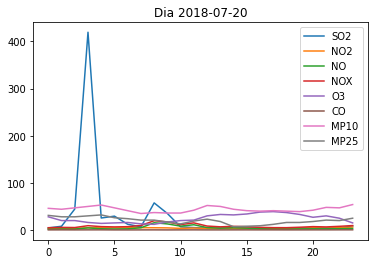

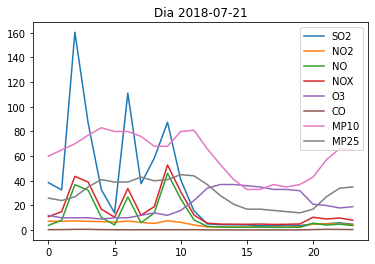

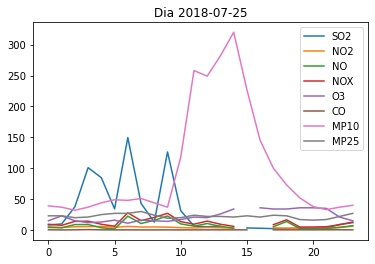

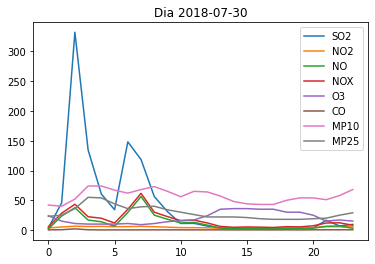

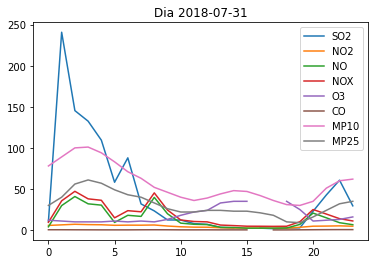

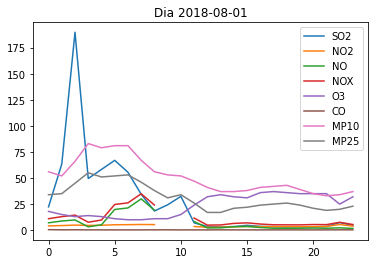

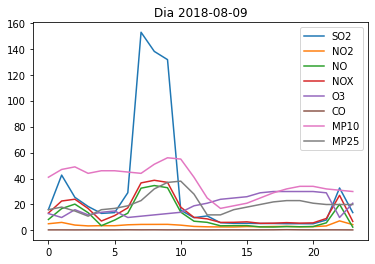

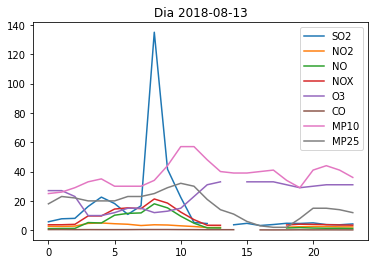

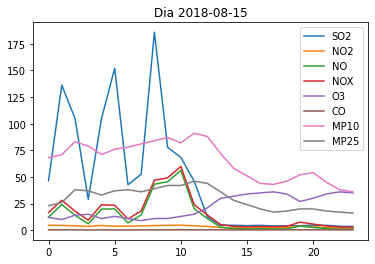

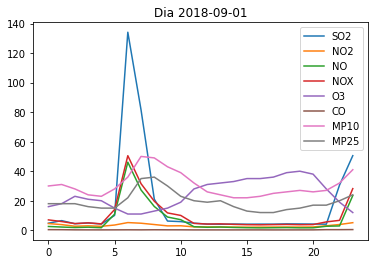

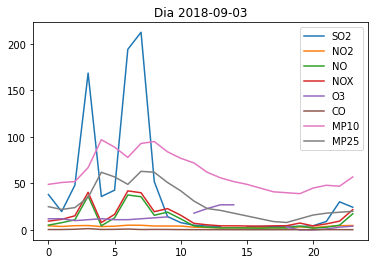

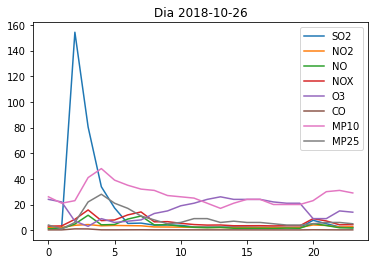

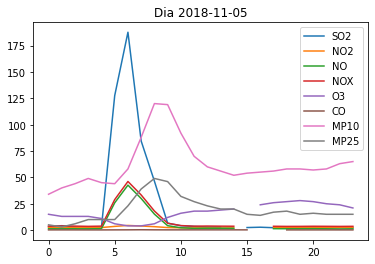

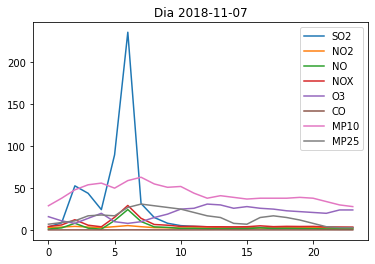

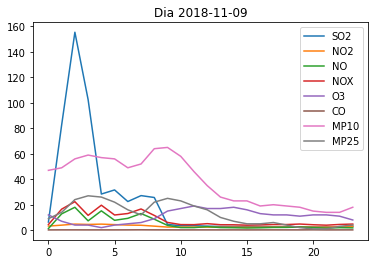

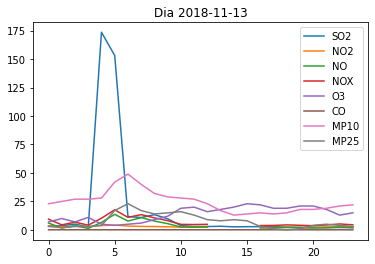

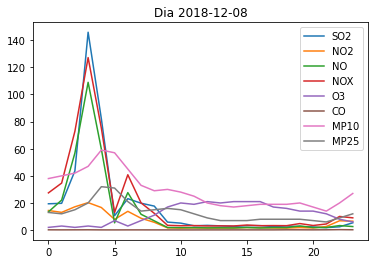

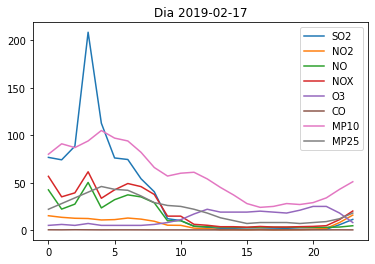

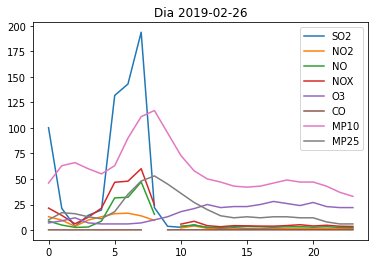

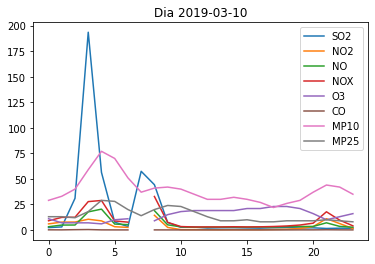

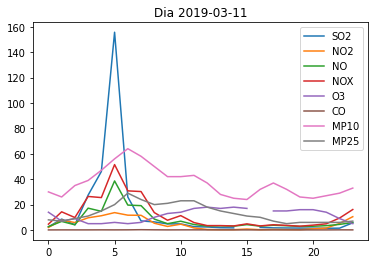

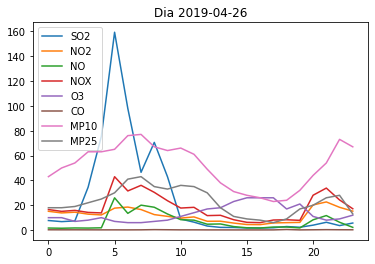

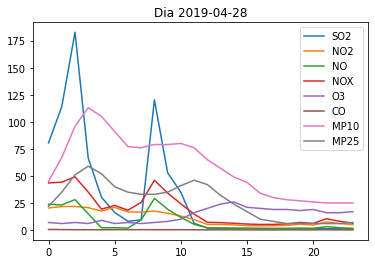

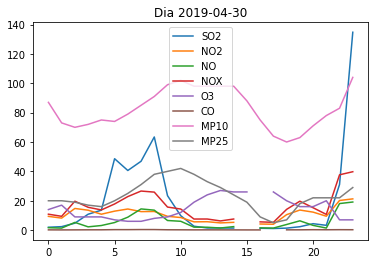

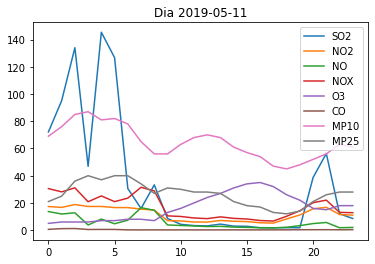

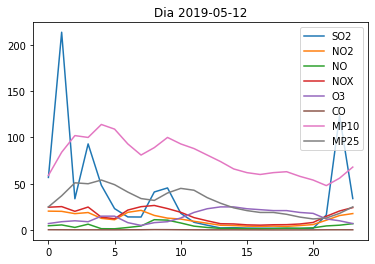

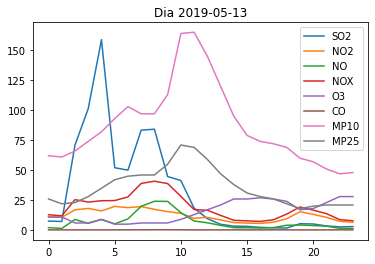

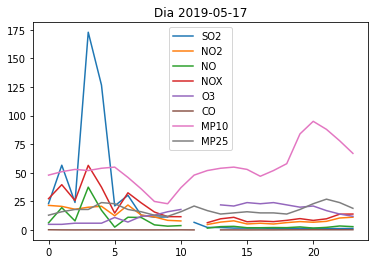

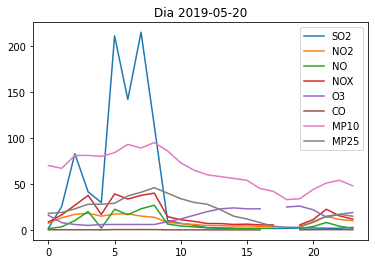

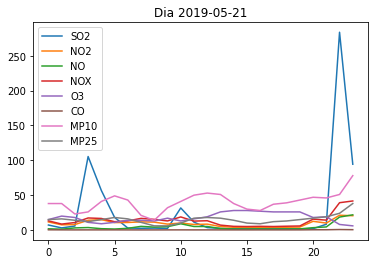

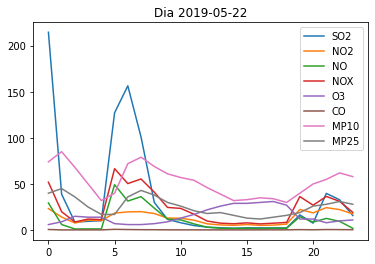

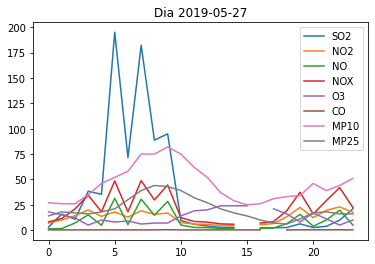

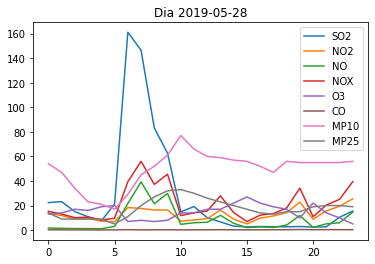

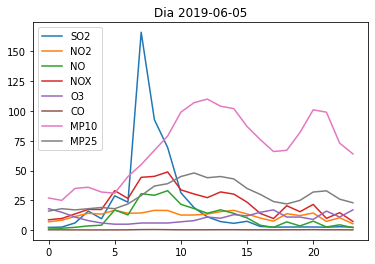

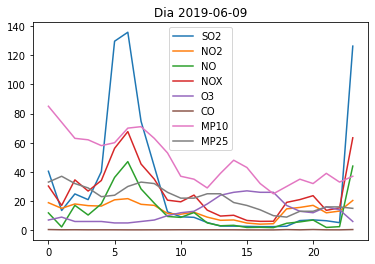

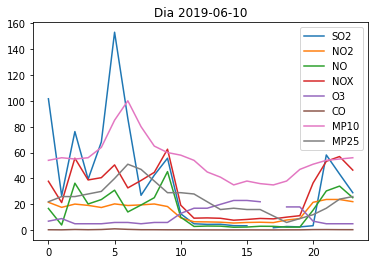

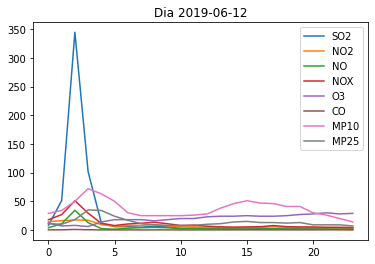

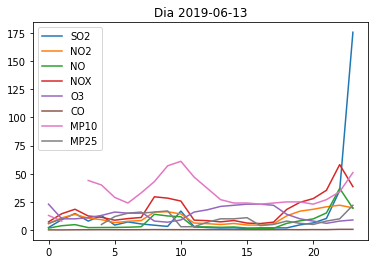

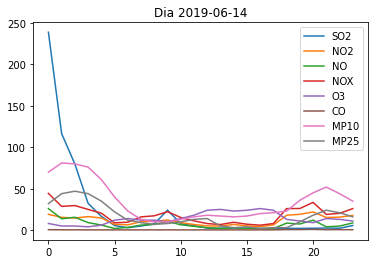

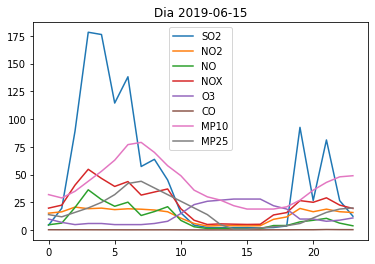

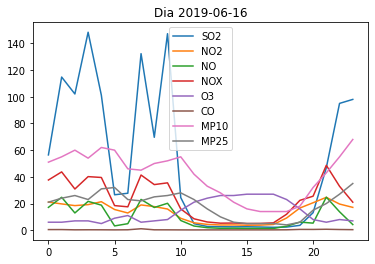

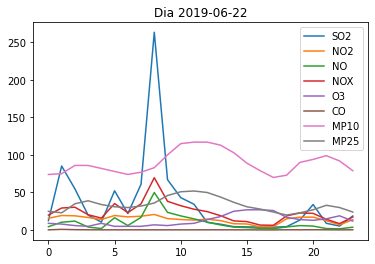

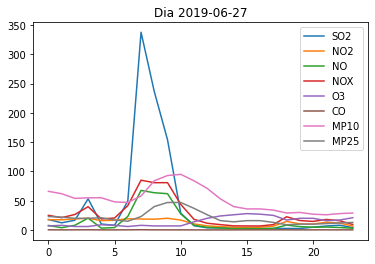

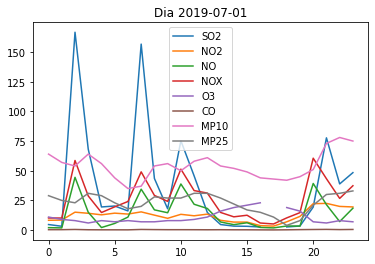

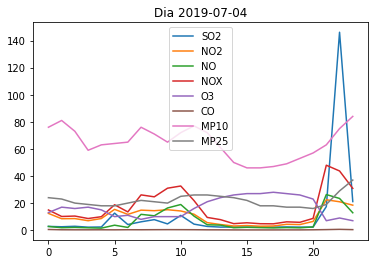

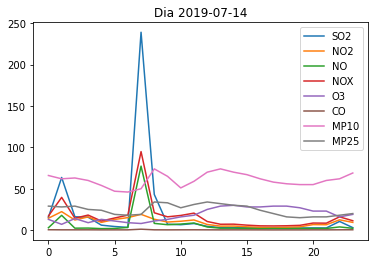

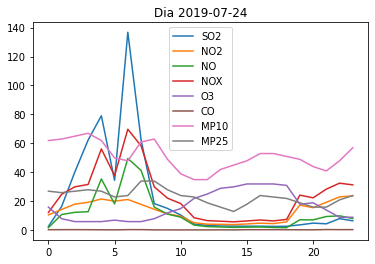

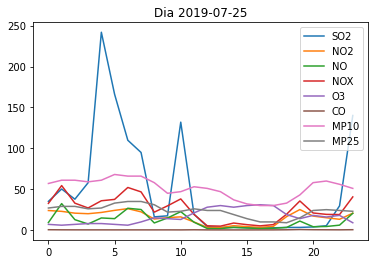

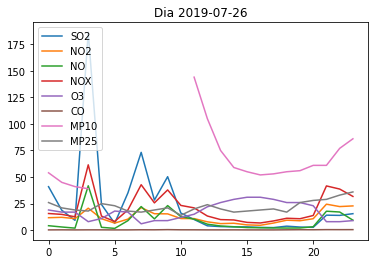

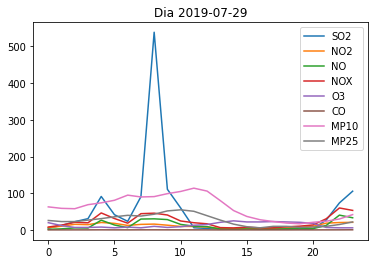

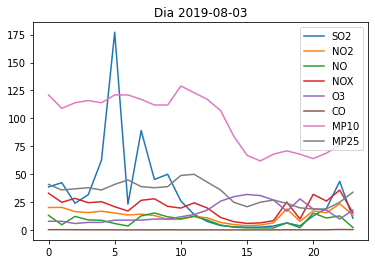

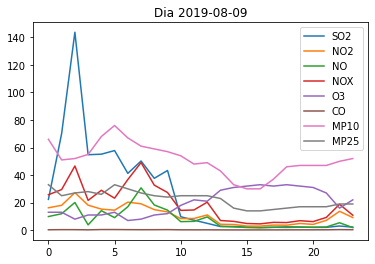

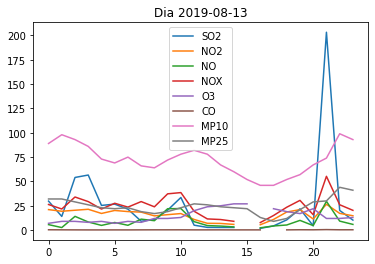

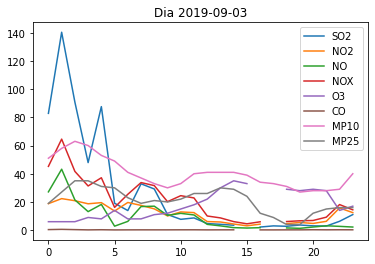

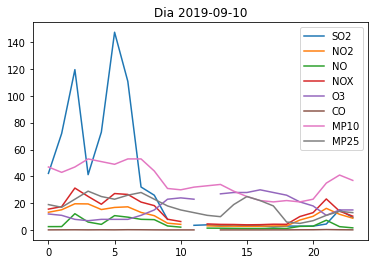

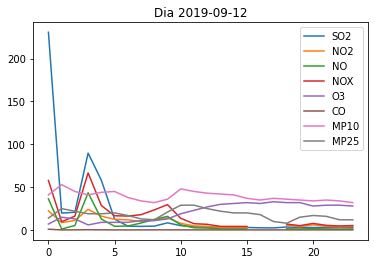

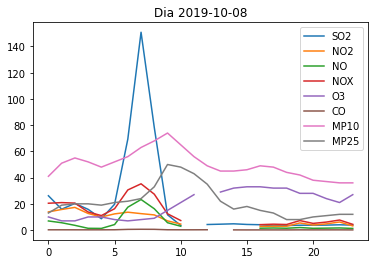

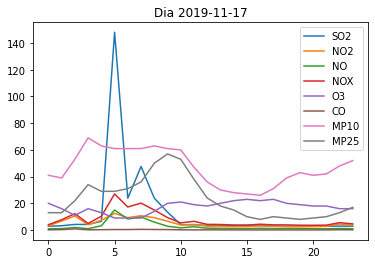

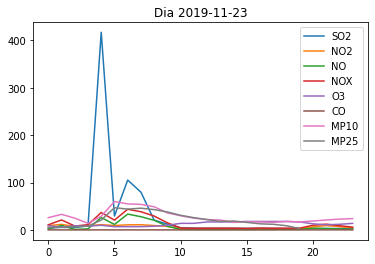

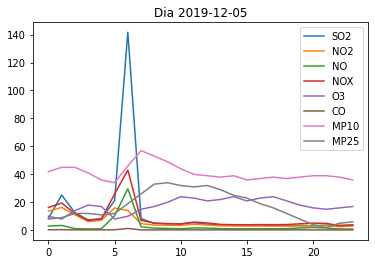

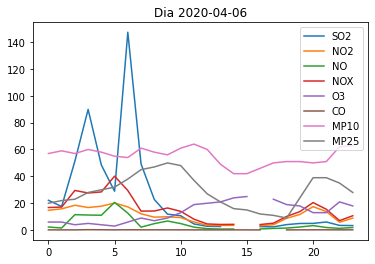

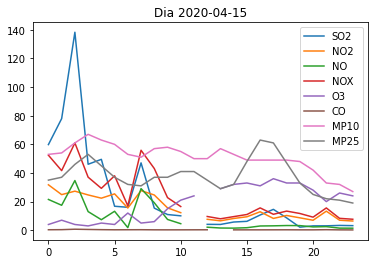

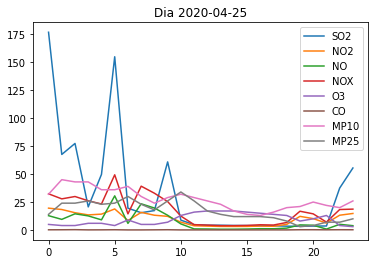

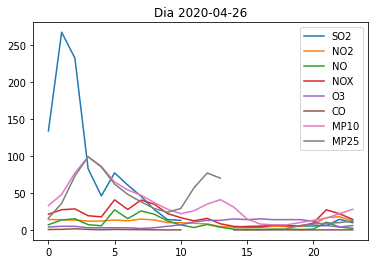

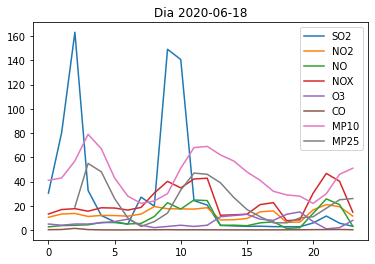

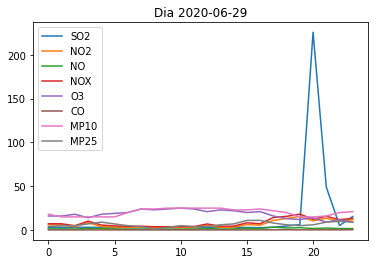

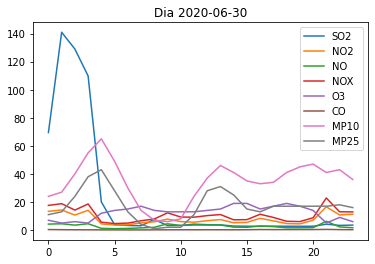

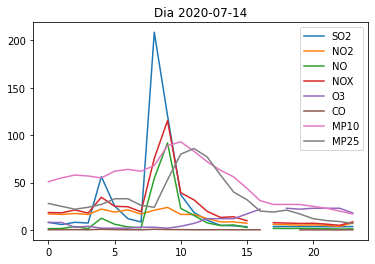

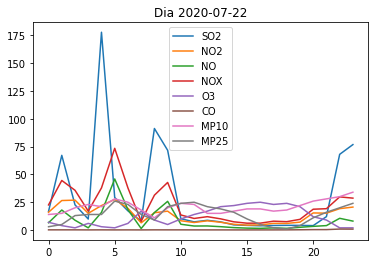

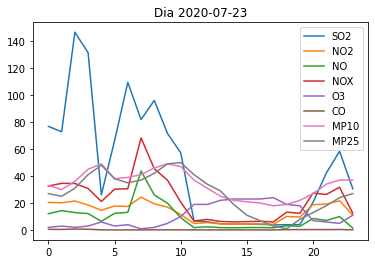

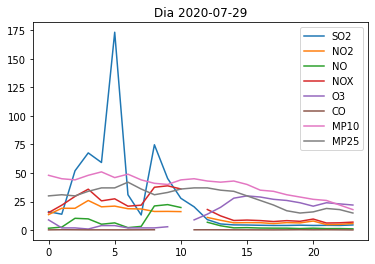

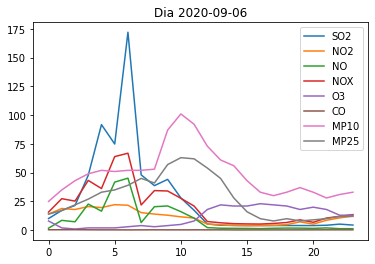

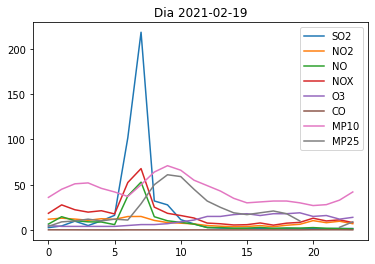

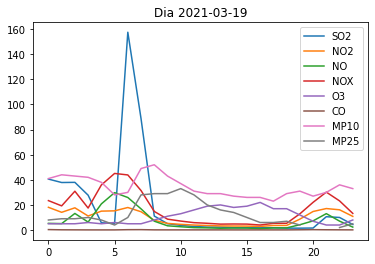

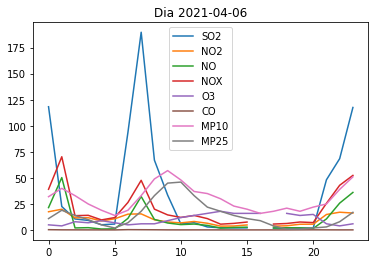

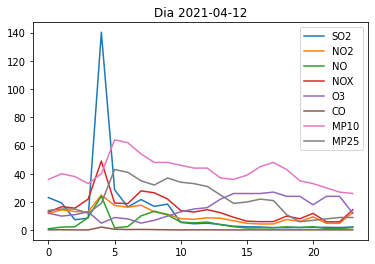

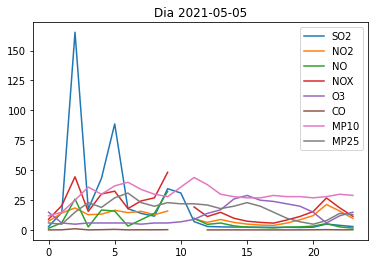

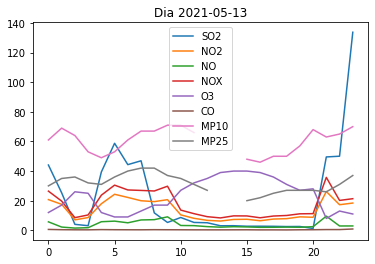

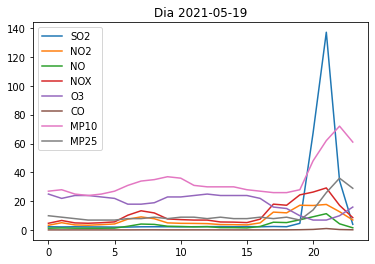

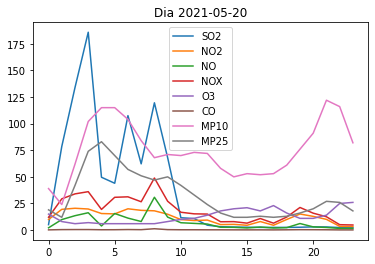

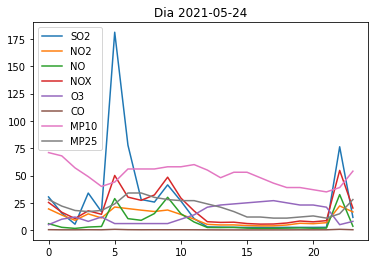

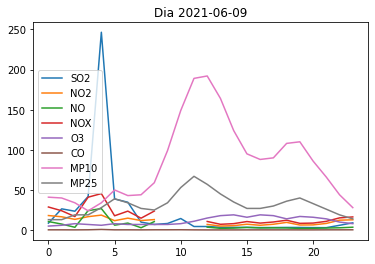

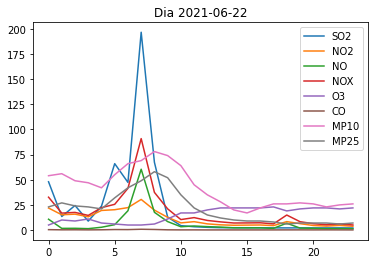

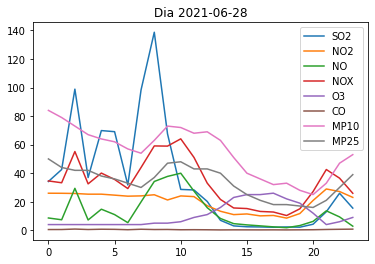

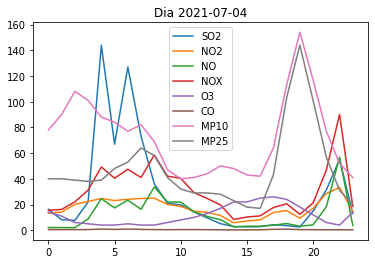

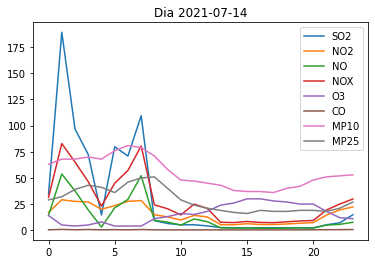

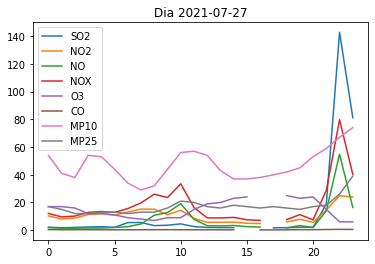

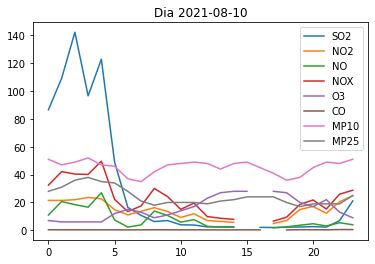

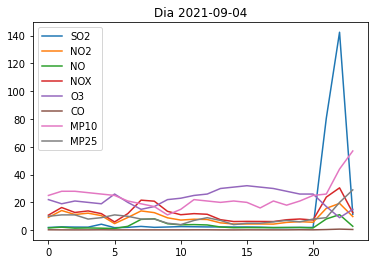

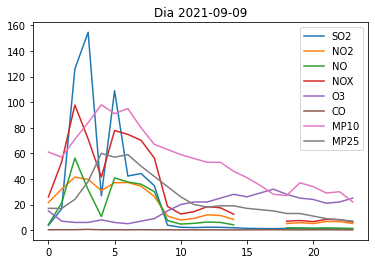

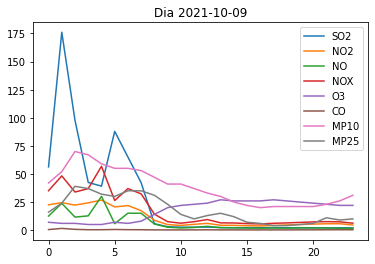

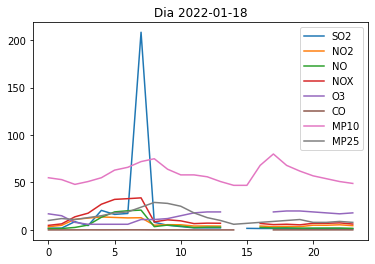

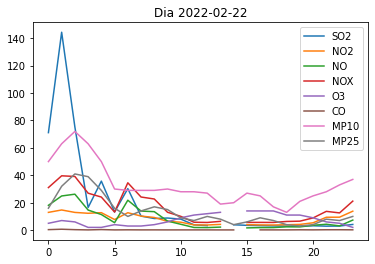

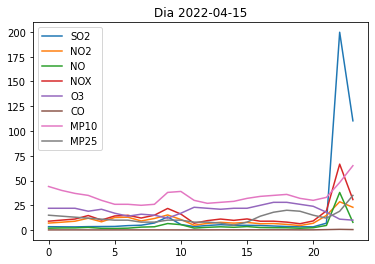

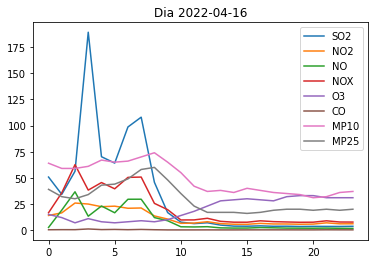

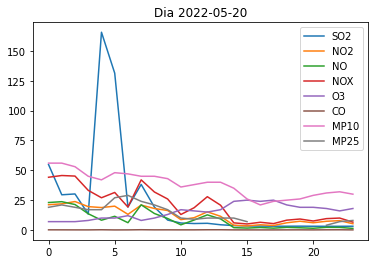

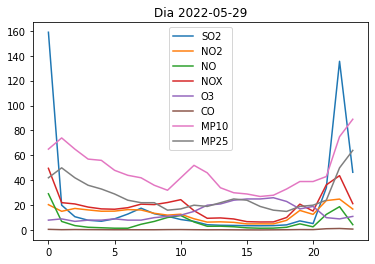

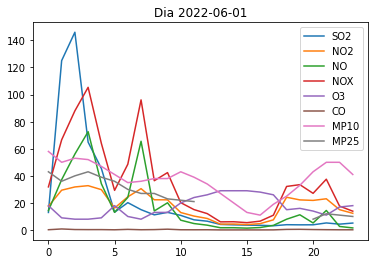

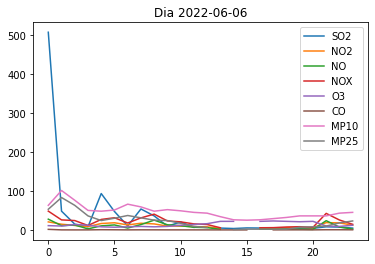

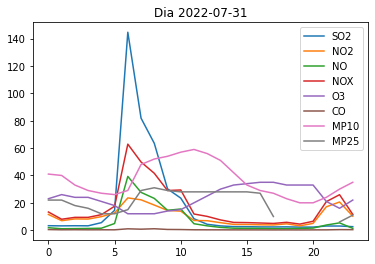

In [14]:
all_var_plot( quintero_all_peaks_df, quintero_all_var_names, 'quintero' )